## imports 

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 로지스틱 회귀의 한계 

In [9]:
df=pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex0.csv')
df.head(3)

,x,underlying,y
0,-1.000000,0.000045,0.0
1,-0.998999,0.000046,0.0
2,-0.997999,0.000047,0.0


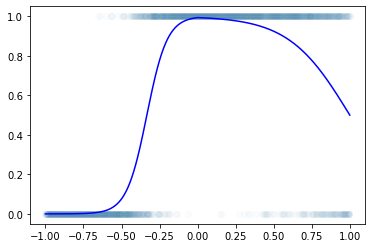

In [10]:
# x가 높아질수록 확률이 높아지다 일정 수준을 넘어서면 오히려 확률이 낮아지는 데이터
plt.plot(df.x,df.y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b') # 이 그래프에 근거해서 0일지 1일지 예측해야함. 즉, given data를 통해 해당 그래프를 만들어서 그 그래프를 이용해 0과 1을 예측하면 됨

### 로지스틱 회귀로 적합

In [11]:
x= torch.tensor(df.x).float().reshape(-1,1)
y= torch.tensor(df.y).float().reshape(-1,1)

In [12]:
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
yhat=net(x)

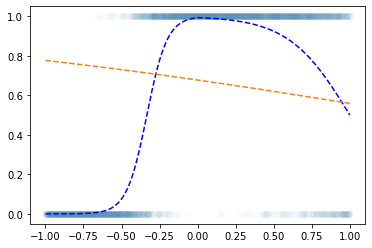

In [18]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data,'--') # 학습 전

In [19]:
loss_fn = torch.nn.BCELoss() 
loss = loss_fn(yhat,y) # loss = -torch.mean((y)*torch.log(yhat)+(1-y)*torch.log(1-yhat))
loss

tensor(0.7680, grad_fn=<BinaryCrossEntropyBackward0>)

In [20]:
optimizr = torch.optim.Adam(net.parameters()) 
# 학습률은 default로 정해진 거 사용중
# lr = ? 이렇게 설정해줘도 됨

In [24]:
for epoc in range(6000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 

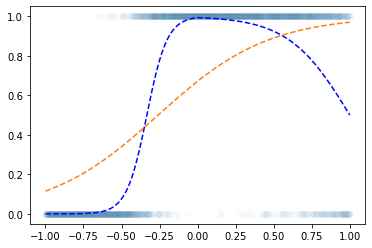

In [25]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'--b')
plt.plot(x,net(x).data,'--') # 학습 후

`-` Epoch을 한 6억번 넣어도 이건 못 맞출 것 같다 (증가하다가 감소하는 underlying을 설계하는 것이 불가능) $\to$ 모형의 표현력이 너무 낮다. 

### 해결책

`-` sigmoid 넣기 전의 상태가 꺽인 그래프 이어야 한다. 

```python
net = torch.nn.Sequential(
    torch.nn.Linear(1,1),
    torch.nn.Sigmoid()
)
yhat=net(x)
```
- 이때, torch.nn.Linear(1,1)가 선형이 아닌 꺾인 선이어야 한다는 것...

In [26]:
sig = torch.nn.Sigmoid()

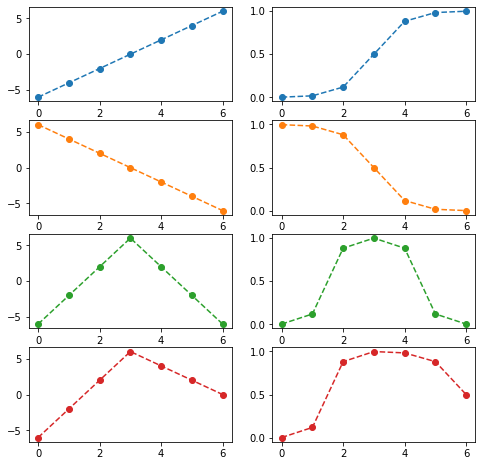

In [27]:
fig,ax = plt.subplots(4,2,figsize=(8,8))
u1 = torch.tensor([-6,-4,-2,0,2,4,6])
u2 = torch.tensor([6,4,2,0,-2,-4,-6])
u3 = torch.tensor([-6,-2,2,6,2,-2,-6])
u4 = torch.tensor([-6,-2,2,6,4,2,0])
ax[0,0].plot(u1,'--o',color='C0');ax[0,1].plot(sig(u1),'--o',color='C0')
ax[1,0].plot(u2,'--o',color='C1');ax[1,1].plot(sig(u2),'--o',color='C1')
ax[2,0].plot(u3,'--o',color='C2');ax[2,1].plot(sig(u3),'--o',color='C2')
ax[3,0].plot(u4,'--o',color='C3');ax[3,1].plot(sig(u4),'--o',color='C3')

## DNN을 이용한 해결 

`-` 목표: 아래와 같은 벡터 ${\boldsymbol u}$를 만들어보자. 

${\boldsymbol u} = [u_1,u_2,\dots,u_{2000}], \quad u_i = \begin{cases} 9x_i +4.5& x_i <0 \\ -4.5x_i + 4.5& x_i >0 \end{cases}$

### 꺽인 그래프를 만드는 방법1
- 낮은 확장성

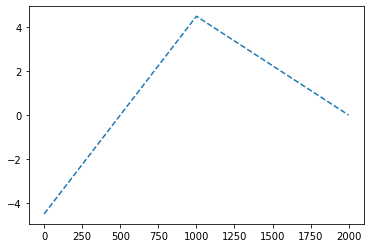

In [30]:
u = [9*xi+4.5 if xi <0 else -4.5*xi+4.5 for xi in x.reshape(-1).tolist()]
plt.plot(u,'--')

### 꺽인 그래프를 만드는 방법2

`-` 전략: 선형변환 $\to$ ReLU $\to$ 선형변환 

(예비학습) ReLU 함수란?

$ReLU(x) = \max(0,x)$

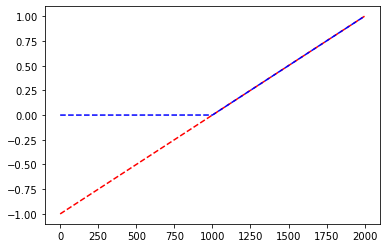

In [31]:
relu=torch.nn.ReLU()
plt.plot(x,'--r')
plt.plot(relu(x),'--b')

우리 전략 다시 확인: 선형변환1 -> 렐루 -> 선형변환2

***(선형변환1)***

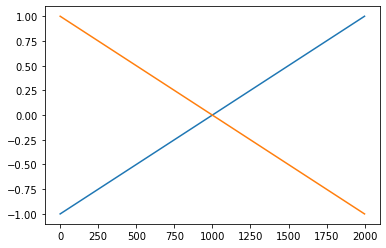

In [44]:
plt.plot(x);plt.plot(-x)

***(렐루)***

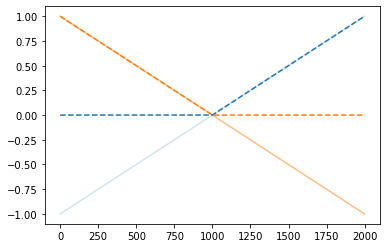

In [45]:
plt.plot(x,alpha=0.2);plt.plot(-x,alpha=0.5)
plt.plot(relu(x),'--',color='C0');plt.plot(relu(-x),'--',color='C1')

***(선형변환2)***

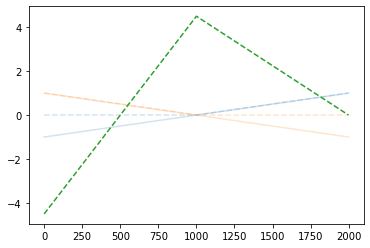

In [46]:
plt.plot(x,alpha=0.2);plt.plot(-x,alpha=0.2)
plt.plot(relu(x),'--',color='C0',alpha=0.2);plt.plot(relu(-x),'--',color='C1',alpha=0.2)
plt.plot(-4.5*relu(x)-9.0*relu(-x)+4.5,'--',color='C2')

이제 초록색선에 sig를 취하기만 하면?

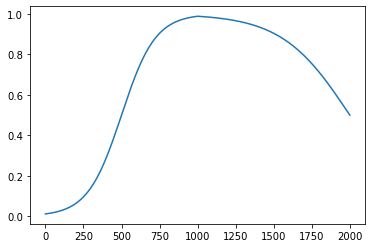

In [48]:
plt.plot(sig(-4.5*relu(x)-9.0*relu(-x)+4.5))
# x축이 2000인 건 data 개수임

정리하면!

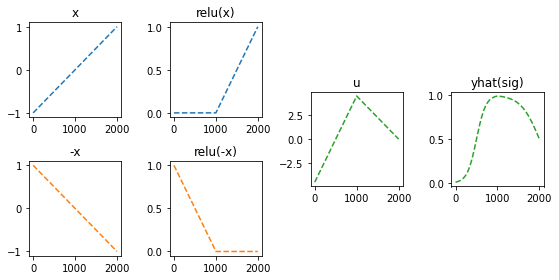

In [50]:
fig = plt.figure(figsize=(8, 4))
spec = fig.add_gridspec(4, 4)
ax1 = fig.add_subplot(spec[:2,0]); ax1.set_title('x'); ax1.plot(x,'--',color='C0')
ax2 = fig.add_subplot(spec[2:,0]); ax2.set_title('-x'); ax2.plot(-x,'--',color='C1')
ax3 = fig.add_subplot(spec[:2,1]); ax3.set_title('relu(x)'); ax3.plot(relu(x),'--',color='C0')
ax4 = fig.add_subplot(spec[2:,1]); ax4.set_title('relu(-x)'); ax4.plot(relu(-x),'--',color='C1')
ax5 = fig.add_subplot(spec[1:3,2]); ax5.set_title('u'); ax5.plot(-4.5*relu(x)-9*relu(-x)+4.5,'--',color='C2')
ax6 = fig.add_subplot(spec[1:3,3]); ax6.set_title('yhat(sig)'); ax6.plot(sig(-4.5*relu(x)-9*relu(-x)+4.5),'--',color='C2')
fig.tight_layout()

- 이런느낌으로 $\hat{\boldsymbol y}$을 만들면 된다. 

### torch.nn.Linear()를 이용한 꺽인 그래프 구현 

In [51]:
torch.manual_seed(43052)
l1 = torch.nn.Linear(in_features=1,out_features=2,bias=True) 
a1 = torch.nn.ReLU()
l2 = torch.nn.Linear(in_features=2,out_features=1,bias=True) 
a2 = torch.nn.Sigmoid() 

In [52]:
net = torch.nn.Sequential(l1,a1,l2,a2) 

In [53]:
l1.weight,l1.bias,l2.weight,l2.bias

(Parameter containing:
 tensor([[-0.3467],
         [-0.8470]], requires_grad=True),
 Parameter containing:
 tensor([0.3604, 0.9336], requires_grad=True),
 Parameter containing:
 tensor([[ 0.2880, -0.6282]], requires_grad=True),
 Parameter containing:
 tensor([0.2304], requires_grad=True))

In [54]:
l1.weight.data = torch.tensor([[1.0],[-1.0]])
l1.bias.data = torch.tensor([0.0, 0.0])
l2.weight.data = torch.tensor([[ -4.5, -9.0]])
l2.bias.data= torch.tensor([4.5])
l1.weight,l1.bias,l2.weight,l2.bias

(Parameter containing:
 tensor([[ 1.],
         [-1.]], requires_grad=True),
 Parameter containing:
 tensor([0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[-4.5000, -9.0000]], requires_grad=True),
 Parameter containing:
 tensor([4.5000], requires_grad=True))

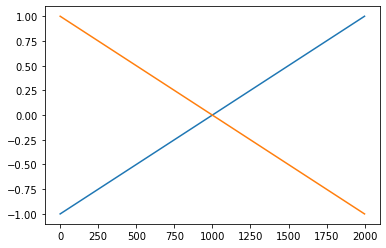

In [55]:
plt.plot(l1(x).data)

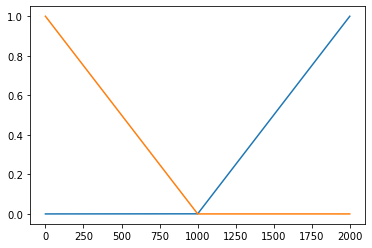

In [56]:
plt.plot(a1(l1(x)).data)

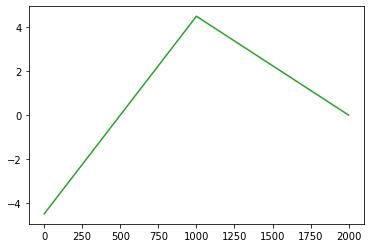

In [57]:
plt.plot(l2(a1(l1(x))).data,color='C2')

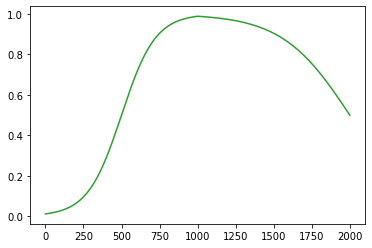

In [59]:
# sig 태우기
plt.plot(a2(l2(a1(l1(x)))).data,color='C2')
#plt.plot(net(x).data,color='C2')

`-` 수식표현

1. ${\bf X}=\begin{bmatrix} x_1 \\ \dots \\ x_n \end{bmatrix}$

2. $l_1({\bf X})={\bf X}{\bf W}^{(1)}\overset{bc}{+} {\boldsymbol b}^{(1)}=\begin{bmatrix} x_1 & -x_1 \\ x_2 & -x_2 \\ \dots & \dots \\  x_n & -x_n\end{bmatrix}$
    - ${\bf W}^{(1)}=\begin{bmatrix} 1 & -1 \end{bmatrix}$
    - ${\boldsymbol b}^{(1)}=\begin{bmatrix} 0 & 0 \end{bmatrix}$

3. $(a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big)=\begin{bmatrix} \text{relu}(x_1) & \text{relu}(-x_1) \\ \text{relu}(x_2) & \text{relu}(-x_2) \\ \dots & \dots \\  \text{relu}(x_n) & \text{relu}(-x_n)\end{bmatrix}$

4. $(l_2 \circ a_1\circ l_1)({\bf X})=\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}\\ =\begin{bmatrix} -4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5 \\ -4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \\ \dots  \\ -4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \end{bmatrix}$ 
    - ${\bf W}^{(2)}=\begin{bmatrix} -4.5 \\ -9 \end{bmatrix}$
    - $b^{(2)}=4.5$

5. $net({\bf X})=(a_2 \circ l_2 \circ a_1\circ l_1)({\bf X})=\text{sig}\Big(\text{relu}\big({\bf X}{\bf W}^{(1)}\overset{bc}{+}{\boldsymbol b}^{(1)}\big){\bf W}^{(2)}\overset{bc}{+}b^{(2)}\Big)\\=\begin{bmatrix} \text{sig}\Big(-4.5\times\text{relu}(x_1) -9.0 \times \text{relu}(-x_1) +4.5\Big) \\ \text{sig}\Big(-4.5\times\text{relu}(x_2) -9.0 \times\text{relu}(-x_2) + 4.5 \Big)\\ \dots  \\ \text{sig}\Big(-4.5\times \text{relu}(x_n) -9.0 \times\text{relu}(-x_n)+4.5 \Big)\end{bmatrix}$ 


`-` 차원만 따지자

$\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,2)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,2)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

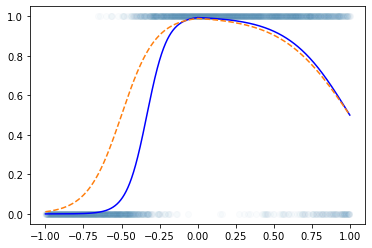

In [60]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

### Step1 ~ Step4

`-` 준비

In [61]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=2), #u1=l1(x), x:(n,1) --> u1:(n,2) 
    torch.nn.ReLU(), # v1=a1(u1), u1:(n,2) --> v1:(n,2) 
    torch.nn.Linear(in_features=2,out_features=1), # u2=l2(v1), v1:(n,2) --> u2:(n,1) 
    torch.nn.Sigmoid() # v2=a2(u2), u2:(n,1) --> v2:(n,1) 
) 

In [62]:
loss_fn = torch.nn.BCELoss()

In [63]:
optimizr = torch.optim.Adam(net.parameters()) # lr은 디폴트값으로..

`-` 반복 

Text(0.5, 1.0, 'before')

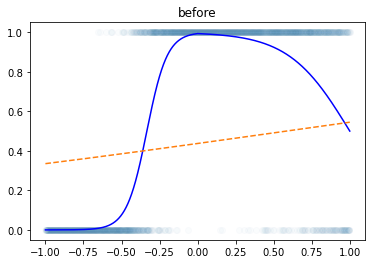

In [64]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')
plt.title("before")

In [65]:
for epoc in range(3000):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y) 
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

Text(0.5, 1.0, 'after 3000 epochs')

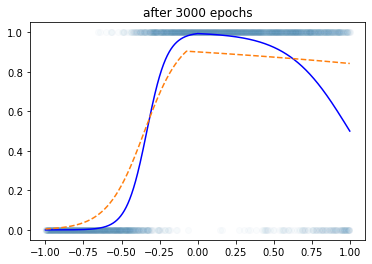

In [66]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--',color='C1')
plt.title("after 3000 epochs")

In [67]:
for epoc in range(3000):
    ## step1 
    yhat = net(x) 
    ## step2 
    loss = loss_fn(yhat,y) 
    ## step3
    loss.backward()
    ## step4 
    optimizr.step()
    optimizr.zero_grad()

Text(0.5, 1.0, 'after 6000 epochs')

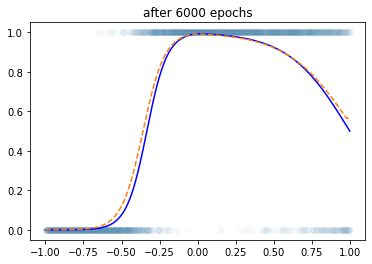

In [68]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(x,df.underlying,'-b')
plt.plot(x,net(x).data,'--',color='C1')
plt.title("after 6000 epochs")

## DNN으로 해결가능한 다양한 예제

### 예제1

`-` 언뜻 생각하면 방금 배운 기술은 sig를 취하기 전이 꺽은선인 형태만 가능할 듯 하다. $\to$ 그래서 이 역시 표현력이 부족할 듯 하다. $\to$ 그런데 생각보다 표현력이 풍부한 편이다. 즉 생각보다 쓸 만하다. 

In [69]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex1.csv')

In [70]:
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)

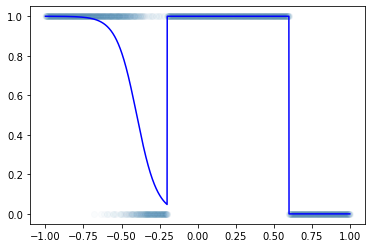

In [71]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')

- 이거 시그모이드 취하기 직전은 step이 포함된 듯 $\to$ 그래서 꺽은선으로는 표현할 수 없는 구조임 $\to$ 그런데 사실 대충은 표현가능 

In [72]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=16), # x:(n,1) --> u1:(n,16) 
    torch.nn.ReLU(), # u1:(n,16) --> v1:(n,16)
    torch.nn.Linear(in_features=16,out_features=1), # v1:(n,16) --> u2:(n,1) 
    torch.nn.Sigmoid() # u2:(n,1) --> v2:(n,1) 
)

- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,16)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,16)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [73]:
loss_fn = torch.nn.BCELoss()

In [74]:
optimizr = torch.optim.Adam(net.parameters())

In [75]:
for epoc in range(6000):
    ## 1
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()    

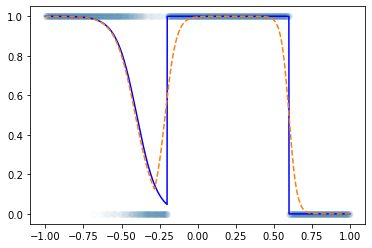

In [76]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

### 예제2

`-` 사실 꺽은선의 조합으로 꽤 많은걸 표현할 수 있거든요? $\to$ 심지어 곡선도 대충 맞게 적합된다. 

In [77]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex2.csv')

In [78]:
x = torch.tensor(df.x).float().reshape(-1,1)
y = torch.tensor(df.y).float().reshape(-1,1)

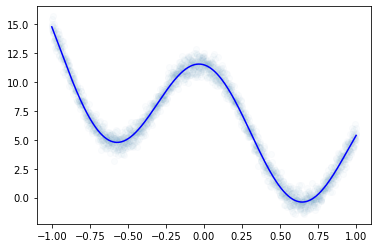

In [79]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')

In [80]:
x=torch.tensor(df.x).float().reshape(-1,1)
y=torch.tensor(df.y).float().reshape(-1,1)

(풀이1)

In [81]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=32), # x:(n,1) --> u1:(n,32)
    torch.nn.ReLU(), # u1:(n,32) --> v1:(n,32) 
    torch.nn.Linear(in_features=32,out_features=1) # v1:(n,32) --> u2:(n,1)
)

- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [82]:
loss_fn = torch.nn.MSELoss() 

In [83]:
optimizr = torch.optim.Adam(net.parameters())

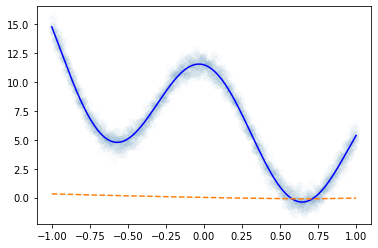

In [84]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

In [85]:
for epoc in range(6000): 
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

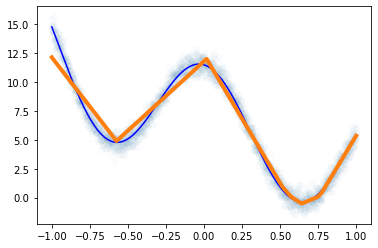

In [86]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,lw=4)

(풀이2) -- 풀이1보다 좀 더 잘맞음. 잘 맞는 이유? 좋은초기값 (=운) 

In [87]:
torch.manual_seed(5)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=1,out_features=32), # x:(n,1) --> u1:(n,32)
    torch.nn.ReLU(), # u1:(n,32) --> v1:(n,32) 
    torch.nn.Linear(in_features=32,out_features=1) # v1:(n,32) --> u2:(n,1)
)

- $\underset{(n,1)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [88]:
loss_fn = torch.nn.MSELoss() 

In [89]:
optimizr = torch.optim.Adam(net.parameters())

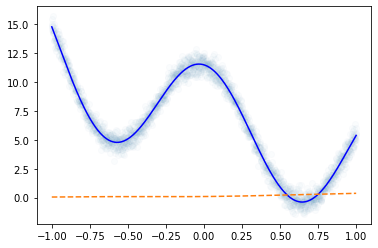

In [90]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,'--')

In [91]:
for epoc in range(6000): 
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

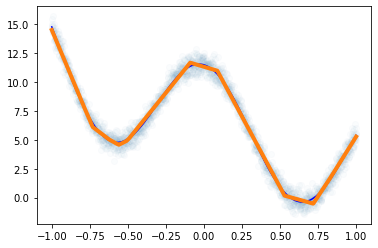

In [92]:
plt.plot(x,y,'o',alpha=0.02)
plt.plot(df.x,df.underlying,'-b')
plt.plot(x,net(x).data,lw=4)

- 풀이1에서 에폭을 많이 반복하면 풀이2의 적합선이 나올까? --> 안나옴!! (local min에 빠졌다) 

### 예제3

In [93]:
import seaborn as sns

In [94]:
df = pd.read_csv('https://raw.githubusercontent.com/guebin/DL2022/master/_notebooks/2022-10-04-dnnex3.csv')
df

,x1,x2,y
0,-0.874139,0.210035,0.0
1,-1.143622,-0.835728,1.0
2,-0.383906,-0.027954,0.0
3,2.131652,0.748879,1.0
4,2.411805,0.925588,1.0
...,...,...,...
1995,-0.002797,-0.040410,0.0
1996,-1.003506,1.182736,0.0
1997,1.388121,0.079317,0.0
1998,0.080463,0.816024,1.0


<AxesSubplot:xlabel='x1', ylabel='x2'>

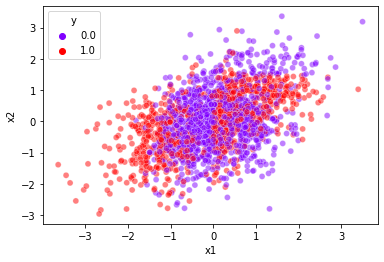

In [95]:
sns.scatterplot(data=df,x='x1',y='x2',hue='y',alpha=0.5,palette={0:(0.5, 0.0, 1.0),1:(1.0,0.0,0.0)})

In [96]:
x1 = torch.tensor(df.x1).float().reshape(-1,1) 
x2 = torch.tensor(df.x2).float().reshape(-1,1) 
X = torch.concat([x1,x2],axis=1) 
y = torch.tensor(df.y).float().reshape(-1,1) 

In [97]:
X.shape

torch.Size([2000, 2])

In [100]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Linear(in_features=2,out_features=32),# in_features가 2 !!
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32,out_features=1),
    torch.nn.Sigmoid()
)

- $\underset{(n,2)}{\bf X} \overset{l_1}{\to} \underset{(n,32)}{\boldsymbol u^{(1)}} \overset{a_1}{\to} \underset{(n,32)}{\boldsymbol v^{(1)}} \overset{l_1}{\to} \underset{(n,1)}{\boldsymbol u^{(2)}} \overset{a_2}{\to} \underset{(n,1)}{\boldsymbol v^{(2)}}=\underset{(n,1)}{\hat{\boldsymbol y}}$

In [101]:
loss_fn = torch.nn.BCELoss() 

In [102]:
optimizr = torch.optim.Adam(net.parameters()) 

In [103]:
for epoc in range(3000):
    ## 1 
    yhat = net(X) 
    ## 2 
    loss = loss_fn(yhat,y) 
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad() 

In [104]:
df2 = df.assign(yhat=yhat.reshape(-1).detach().tolist())
df2

,x1,x2,y,yhat
0,-0.874139,0.210035,0.0,0.344423
1,-1.143622,-0.835728,1.0,0.604281
2,-0.383906,-0.027954,0.0,0.110590
3,2.131652,0.748879,1.0,0.920506
4,2.411805,0.925588,1.0,0.918970
...,...,...,...,...
1995,-0.002797,-0.040410,0.0,0.260841
1996,-1.003506,1.182736,0.0,0.489265
1997,1.388121,0.079317,0.0,0.403746
1998,0.080463,0.816024,1.0,0.263182


<AxesSubplot:xlabel='x1', ylabel='x2'>

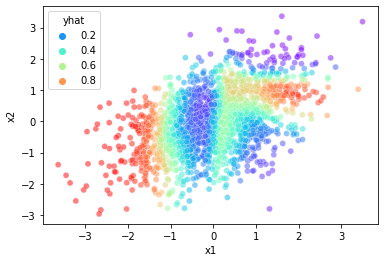

In [105]:
sns.scatterplot(data=df2,x='x1',y='x2',hue='yhat',alpha=0.5,palette='rainbow')

`-` 결과시각화 

<AxesSubplot:xlabel='x1', ylabel='x2'>

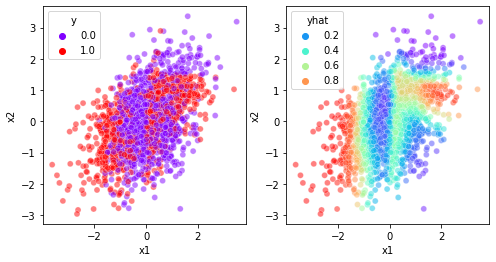

In [106]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
sns.scatterplot(data=df,x='x1',y='x2',hue='y',alpha=0.5,palette={0:(0.5, 0.0, 1.0),1:(1.0,0.0,0.0)},ax=ax[0])
sns.scatterplot(data=df2,x='x1',y='x2',hue='yhat',alpha=0.5,palette='rainbow',ax=ax[1])

`-` 교훈: underlying이 엄청 이상해보여도 생각보다 잘 맞춤